## 1. EDA

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt

import warnings

warnings.filterwarnings("ignore", category=UserWarning)

RANDOM_SEED = 42

print(f"Running on PyMC v{pm.__version__}")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC v5.10.3


In [2]:
import pandas as pd

df = pd.read_csv("bayesdata.csv")

In [3]:
df.head()

,player_id,game_id,date,points,3_pointers,rebounds,assists,steals,blocks,turnovers,double_double,triple_double,dfs_points
0,1630173,22300432,"DEC 29, 2023",0,0,2,0,0,0,0,0,0,2.50
1,1630173,22300416,"DEC 27, 2023",3,0,1,0,1,1,1,0,0,7.75
2,1630173,22300395,"DEC 23, 2023",8,0,2,1,0,2,0,0,0,16.00
3,1630173,22300382,"DEC 22, 2023",4,0,6,1,2,0,1,0,0,16.50
4,1630173,22300369,"DEC 20, 2023",13,1,5,1,1,1,1,0,0,24.75


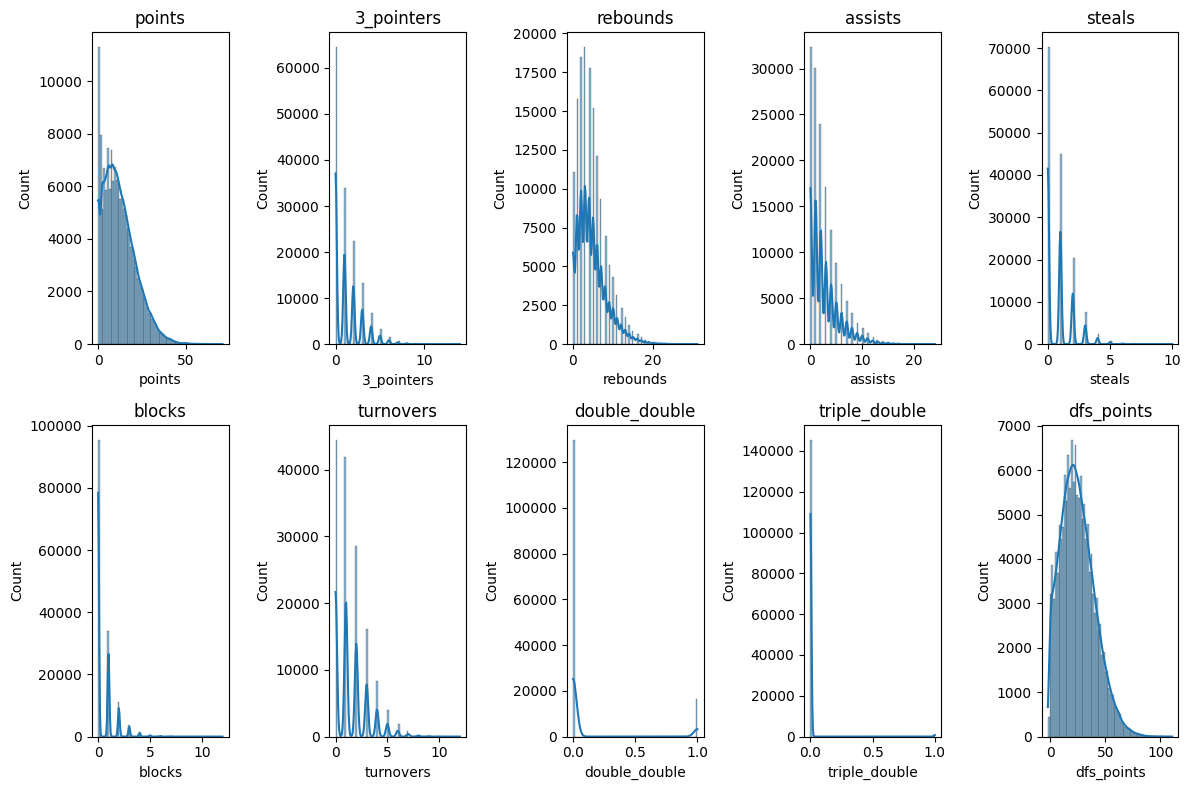

In [4]:
columns = [
    "points",
    "3_pointers",
    "rebounds",
    "assists",
    "steals",
    "blocks",
    "turnovers",
    "double_double",
    "triple_double",
    "dfs_points"
    
]

# Set up a 2x4 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 8))

# Flatten the 2D array of subplots to a 1D array
axes = axes.flatten()

# Iterate through columns and create histograms
for i, column in enumerate(columns):
    sns.histplot(x=df[column], bins=70, ax=axes[i], kde=True)
    axes[i].set_title(column)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

## 1.5. Write down model shape

https://www.pymc.io/projects/docs/en/v3.11.4/pymc-examples/examples/generalized_linear_models/GLM-poisson-regression.html 

"points",
"3_pointers",
"rebounds",
"assists",
"steals",
"blocks",
"turnovers",
"double_double",
"triple_double",
"dfs_points"


y_dfs = poisson, observed = data['dfs_points']

mu = a * points * 1 + b * 3_pts * 0.5, c * rebounds * ..., d * assists, e * steals, f * blocks, g * turnovers, h * double, i * triple

a, b, c,d,e,f, g = poisson, shape= num players
all above hyperpriors (x_mu) = gamma with find_constrained_priors

lower, upper for (most of density should be between):
a_mu: 0.05, 50
b_mu: 0.05, 10
c_mu: 0.05, 20
d_mu: 0.05, 18
e_mu: 0.05, 5
f_mu: 0.05, 5
g_mu: 0.05, 8


set beta init_guess for all to 1
a guesses for:
a_mu: 15
b_mu: 4
c_mu: 7
d_mu: 5
e_mu: 3
f_mu: 2
g_mu: 3

a_mu = gamma, pre-set find_constrained_priors

h, i = binomial, shape = num players



## 2. Create The Model

### 2.1. Make labels

In [6]:
player_labels = df["player_id"].astype("category").cat.codes.values
df["player_labels"] = df["player_id"].astype("category").cat.codes.values
df.head(5)

,player_id,game_id,date,points,3_pointers,rebounds,assists,steals,blocks,turnovers,double_double,triple_double,dfs_points,player_labels
0,1630173,22300432,"DEC 29, 2023",0,0,2,0,0,0,0,0,0,2.50,290
1,1630173,22300416,"DEC 27, 2023",3,0,1,0,1,1,1,0,0,7.75,290
2,1630173,22300395,"DEC 23, 2023",8,0,2,1,0,2,0,0,0,16.00,290
3,1630173,22300382,"DEC 22, 2023",4,0,6,1,2,0,1,0,0,16.50,290
4,1630173,22300369,"DEC 20, 2023",13,1,5,1,1,1,1,0,0,24.75,290


### 2.2. Make hyperpriors

In [ ]:
with pm.Model() as dfs_model:
    a_mu = pm.find_constrained_prior(
        pm.Gamma,
        lower=8,
        upper=12,
        init_guess={"alpha": 10, "beta": 1},
    )
    

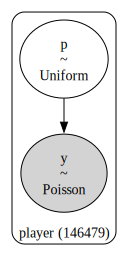

In [6]:
with pm.Model(coords=coords) as uninformative_prior_model:
    p = pm.Uniform("p", 0, 80, dims="player")

    y = pm.Poisson("y",  mu=p, observed=points, dims="player")

pm.model_to_graphviz(uninformative_prior_model)

In [7]:
with uninformative_prior_model:
    uninformed_prior_trace = pm.sample_prior_predictive(1000)

Sampling: [p, y]


<Axes: ylabel='Count'>

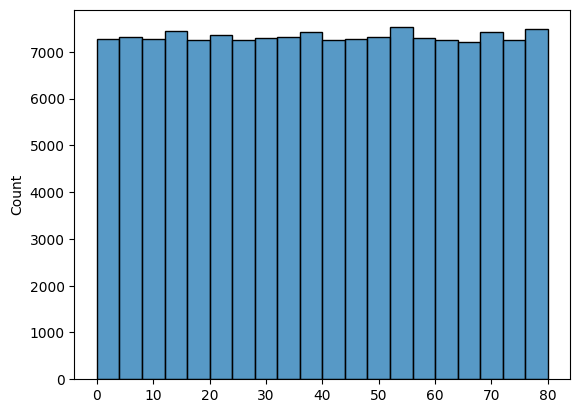

In [8]:
sns.histplot(
    uninformed_prior_trace.prior["p"].sel(chain=[0], draw=[0]).squeeze(), bins=20
)

In [ ]:
y_pred_g = pm.sample_posterior_predictive(
    trace_g, 100, model_g
)  # using the sampled mu/sigma values to make 100 counterfeit y's
data_ppc = az.from_pymc(trace=trace_g, posterior_predictive=y_pred_g)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=False)
ax[0].legend(fontsize=15)

This function will randomly draw 500 samples of parameters from the trace. Then, for each sample, it will draw 100 random numbers from a normal distribution specified by the values of mu and std in that sample.

ppc = pm.sample_ppc(trace, samples=500, model=model, size=100)

Now, ppc contains 500 generated data sets (containing 100 samples each), each using a different parameter setting from the posterior:


np.asarray(ppc['n']).shape

(500, 100)



In [ ]:
# TODO: Plot ppc vs real data